Gato vs Não-Gato

Aluno: Rafael Begnini de Castilhos (20205642)
    
Neste trabalho, será abordado o reconhecimento de padrões por meio do treinamento de uma rede neural. O objetivo é desenvolver um sistema capaz de identificar e classificar imagens de gatinhos como "gatos" ou "não-gatos".

Para isso, utilizaremos um conjunto de dados contendo imagens RGB, representadas por matrizes de 64x64x3 (4096 pixels coloridos). Essas imagens serão usadas como parâmetros de entrada para a rede neural.

O objetivo da rede é atribuir um valor de classificação correto para cada imagem, sendo que o valor 0 corresponderá a "não-gato" e o valor 1 corresponderá a "gato".

Para resolver esse problema, serão explorados três modelos diferentes: um perceptron simples (regressão logística), uma rede neural de camada rasa e uma rede neural convolucional.
Cada modelo terá seu próprio processo de treinamento e teste, visando encontrar a melhor abordagem para a classificação precisa das imagens.

Regressão Logística
Inicialmente, abordaremos o problema utilizando apenas um perceptron, por meio de regressão logística.

Importando as bibliotecas e lendo os dados

In [1]:
# Importando bibliotecas
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Carregando os dados
train_dataset = h5py.File('./train_catvnoncat.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('./test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

Para facilitar a visualização dos dados de treinamento, iremos representá-los em um gráfico.

Tamanho da base de dados de treinamento: 209
train set shape: (209, 64, 64, 3)


Text(0, 0.5, 'Classe')

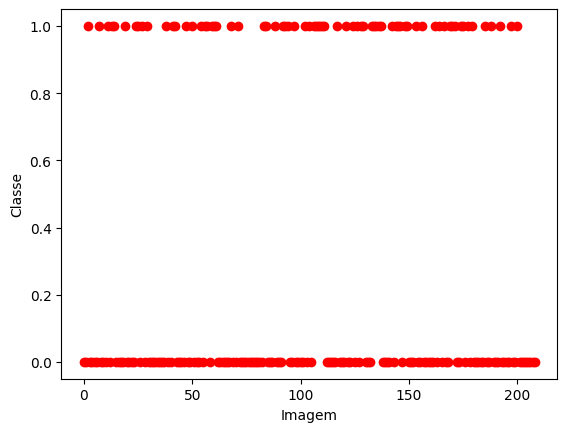

In [2]:
n = len(train_set_x_orig) # número de imagens
print('Tamanho da base de dados de treinamento:', n)
print('train set shape:', train_set_x_orig.shape)

plt.scatter(range(n),train_set_y_orig,c='red')
plt.xlabel('Imagem')
plt.ylabel('Classe')

Nosso conjunto de dados consiste em 209 imagens de tamanho 64x64x3, classificadas como gatos (classe 1) ou não-gatos (classe 0).

Manipulando os dados
Antes de prosseguirmos, faremos um achatamento (flatten) nos vetores de teste e treinamento, além de normalizar os dados de entrada.

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Transformando os arrays em arrays de 209 x 12288 (209 x (64 . 64 . 3))
train_set_x = np.array([array.flatten() for array in train_set_x_orig])
test_set_x = np.array([array.flatten() for array in test_set_x_orig])

# Normalizando o array de treino
norm_train_set_x = MinMaxScaler()
norm_train_set_x = norm_train_set_x.fit_transform(train_set_x)

Modelando a regressão e realizando testes
Com as preparações feitas, iremos modelar a regressão logística e realizar alguns testes.

In [4]:
from sklearn.linear_model import LogisticRegression

# Treinando o modelo de regressão logística
clf = LogisticRegression(random_state=0, max_iter=10000).fit(norm_train_set_x, train_set_y_orig)

print(f'Acurácia sobre o arquivo de treino = {clf.score(train_set_x, train_set_y_orig) * 100}%')
print(f'Acurácia sobre o arquivo de testes = {clf.score(test_set_x, test_set_y_orig) * 100}%')

print('\nResultados esperados do arquivo de teste:', *test_set_y_orig)
print('Resultados obtidos do arquivo de teste:  ', *clf.predict(test_set_x))

Acurácia sobre o arquivo de treino = 100.0%
Acurácia sobre o arquivo de testes = 72.0%

Resultados esperados do arquivo de teste: 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0
Resultados obtidos do arquivo de teste:   1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0


Verificamos que o modelo criado obteve resultados satisfatórios, sendo capaz de identificar com precisão se uma determinada imagem é de um gato ou não em 72% das vezes.

Matriz de confusão
Com base nos resultados obtidos, construímos uma matriz de confusão para avaliar o desempenho do modelo em relação aos dados de teste.

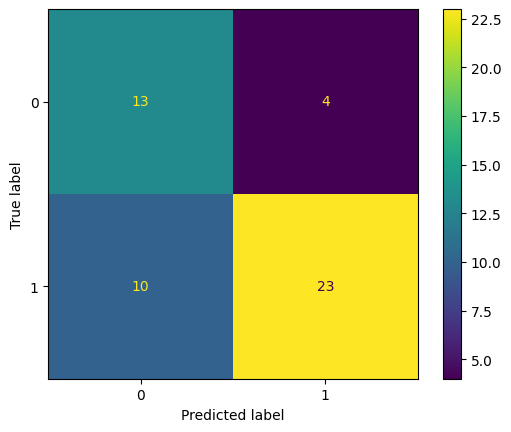

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, test_set_x, test_set_y_orig)

Rede de Camada Rasa
Visando obter um desempenho ainda melhor e resultados mais confiáveis, iremos implementar a classificação de imagens de gatinhos em um modelo mais robusto, com a expectativa de obter respostas mais precisas.


Importando as bibliotecas Keras e Tensorflow

In [7]:
from tensorflow import keras         # Importa Keras
from tensorflow.keras import layers  # Ferramentes do Keras mais usadas para acesso mais rápido
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical

Definindo as classes de classificação
Vamos utilizar duas classes:

*   0 - não-gatos
*   1 - gatos

In [8]:
train_set_y = to_categorical(train_set_y_orig, 2)
test_set_y = to_categorical(test_set_y_orig, 2)

Definindo um novo modelo
Para esta abordagem, vamos utilizar uma rede neural com apenas 3 camadas:
*   uma camada de entrada (*flatten*);
*   uma camada intermediária, composta por 1000 neurônios (com função de ativação sigmóide)
*   uma camada de saída, composta por 2 neurônios (com função de ativação *softmax*).


A rede utilizará o decaimento exponencial da taxa de aprendizado, além de pesos e *bias* aleatórios.

In [9]:
# Decaimento exponencial da taxa de aprendizado
def exp_decay(epoch):
   initial_lrate = 1.0
   k = 0.05
   lrate = initial_lrate * np.exp(-k*epoch)
   return lrate

lrate = keras.callbacks.LearningRateScheduler(exp_decay)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# Definindo a rede
modelo = keras.Sequential()
modelo.add(layers.Flatten())
modelo.add(layers.Dense(1000, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="sigmoid"))
modelo.add(layers.Dense(2, kernel_initializer="random_uniform", bias_initializer="random_uniform", activation="softmax"))

opt = keras.optimizers.SGD()
modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

input_shape = train_set_x.shape
modelo.build(input_shape)

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (209, 12288)              0         
                                                                 
 dense (Dense)               (209, 1000)               12289000  
                                                                 
 dense_1 (Dense)             (209, 2)                  2002      
                                                                 
Total params: 12291002 (46.89 MB)
Trainable params: 12291002 (46.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Criando um conjunto de validação
A fim de acompanhar o progresso da rede, faremos uso de um conjunto de validação composto por 63 fotos.

In [10]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val = train_test_split(norm_train_set_x,train_set_y,test_size = 0.3)
num_train = np.size(x_tr,0)
print(num_train)

146


Treinando o modelo
Agora, iremos treinar o modelo que foi criado, utilizando um tamanho de lote (batch size) de 30 e realizando 2000 épocas.

In [12]:
results = modelo.fit(x_tr, y_tr, validation_data = (x_val, y_val), batch_size = 30, epochs=2000, callbacks=[callback, lrate], verbose=2)

Epoch 1/2000
5/5 - 3s - loss: 38.0977 - accuracy: 0.4932 - val_loss: 32.5975 - val_accuracy: 0.3492 - lr: 1.0000 - 3s/epoch - 550ms/step
Epoch 2/2000
5/5 - 1s - loss: 19.5476 - accuracy: 0.5342 - val_loss: 3.4130 - val_accuracy: 0.3492 - lr: 0.9512 - 1s/epoch - 259ms/step
Epoch 3/2000
5/5 - 2s - loss: 14.5681 - accuracy: 0.4795 - val_loss: 7.2350 - val_accuracy: 0.6508 - lr: 0.9048 - 2s/epoch - 307ms/step
Epoch 4/2000
5/5 - 1s - loss: 7.3997 - accuracy: 0.5685 - val_loss: 13.4205 - val_accuracy: 0.6508 - lr: 0.8607 - 1s/epoch - 228ms/step
Epoch 5/2000
5/5 - 1s - loss: 7.4735 - accuracy: 0.5959 - val_loss: 8.5216 - val_accuracy: 0.3651 - lr: 0.8187 - 1s/epoch - 200ms/step
Epoch 6/2000
5/5 - 1s - loss: 7.9068 - accuracy: 0.4932 - val_loss: 1.1228 - val_accuracy: 0.6508 - lr: 0.7788 - 939ms/epoch - 188ms/step
Epoch 7/2000
5/5 - 1s - loss: 4.0559 - accuracy: 0.5479 - val_loss: 6.3922 - val_accuracy: 0.6508 - lr: 0.7408 - 1s/epoch - 211ms/step
Epoch 8/2000
5/5 - 1s - loss: 4.1918 - accuracy

Desempenho do aprendizado
Podemos observar, por meio de um gráfico, o desempenho do aprendizado ao longo das épocas, representando a acurácia do modelo para os conjuntos de treinamento e validação, bem como o valor da função de custo.

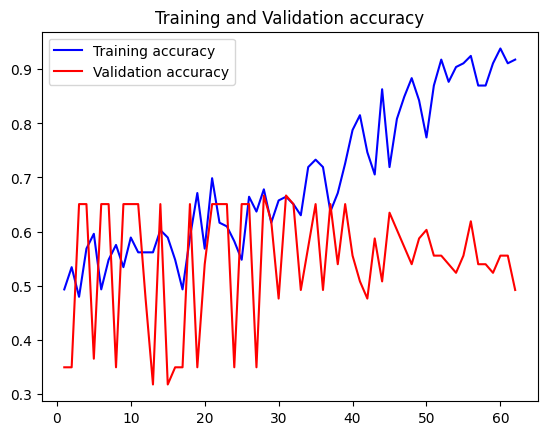

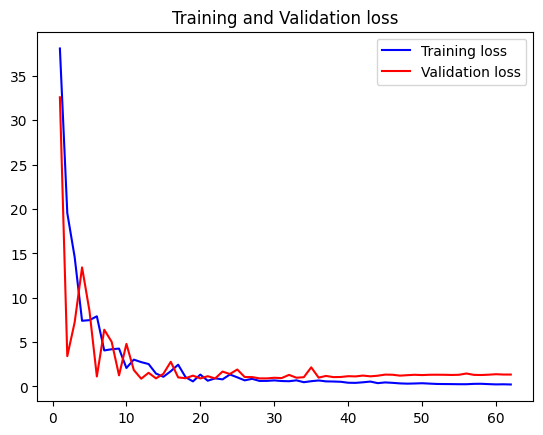

In [13]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label= 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label= 'Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label= 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Desempenho da rede
Após configurar e treinar a rede, realizaremos testes de desempenho para avaliar o funcionamento do modelo.

In [14]:
from sklearn.metrics import accuracy_score

y_train_pred = modelo.predict(train_set_x)
y_test_pred = modelo.predict(test_set_x)

print('Acurácia sobre o arquivo de treino = {:.1f}%'.format(accuracy_score(train_set_y.argmax(axis=1), y_train_pred.argmax(axis=1)) * 100))
print('Acurácia sobre o arquivo de testes = {:.1f}%'.format(accuracy_score(test_set_y.argmax(axis=1), y_test_pred.argmax(axis=1)) * 100))

print('\nResultados esperados do arquivo de teste:', *test_set_y_orig)
print('Resultados obtidos do arquivo de teste:  ', *[y_test_pred[x].argmax() for x in range(len(y_test_pred))])

2/2 [==============================] - 0s 33ms/step
Acurácia sobre o arquivo de treino = 80.9%
Acurácia sobre o arquivo de testes = 80.0%

Resultados esperados do arquivo de teste: 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0
Resultados obtidos do arquivo de teste:   1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0


Matriz de confusão
Com base nos resultados obtidos, será possível construir uma matriz de confusão, que mostrará o desempenho do modelo em relação à base de dados de teste.

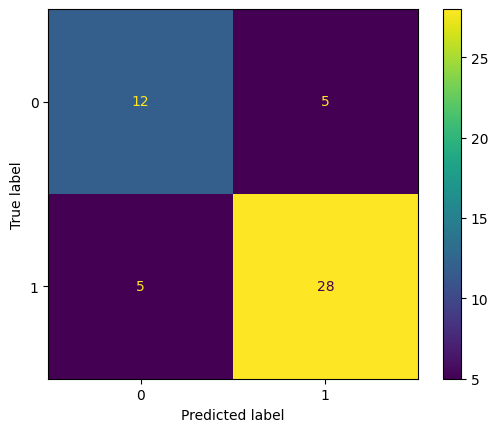

In [15]:
ConfusionMatrixDisplay.from_predictions(test_set_y.argmax(axis=1), y_test_pred.argmax(axis=1))

Rede Convolucional
Agora, vamos utilizar um modelo mais robusto para identificação de imagens.

Criando um conjunto de validação
Novamente, faremos uso de um conjunto de validação, desta vez com 21 fotos.

In [16]:
x_tr,x_val,ytr,y_val = train_test_split(train_set_x_orig,train_set_y,test_size = 0.1)
num_train = np.size(x_tr,0)
print(num_train)

188


Definindo um novo modelo
Para esta abordagem, vamos utilizar uma rede neural com 21 camadas:
*   4 camadas de convolução, com ativação *relu*;
*   9 camadas de normalização do *batch*
*   4 camadas de *pooling*;
*   1 camada *flatten*
*   1 camada de *dropout*;
*   2 camadas NN densas.

In [17]:
model_cnn = keras.Sequential(
    [
        keras.Input(shape=(64,64,3)),
        layers.Conv2D(32, (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation = 'relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512,activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2,activation='softmax'),
    ]
)

model_cnn.compile(
  loss='categorical_crossentropy',
  optimizer='adagrad',
  metrics=['accuracy'],
)
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 31, 31, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                      

Treinando o modelo
Agora treinaremos o modelo criado, utilizando um *batch_size* de tamanho 16 e 100 épocas.

In [18]:
# Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model_cnn.fit(
  x_tr,
  ytr,
  epochs=100,
  batch_size=16,
  validation_data=(x_val, y_val),
  verbose = 2,
  callbacks=[early_stop]
)

Epoch 1/100
12/12 - 4s - loss: 0.9246 - accuracy: 0.5426 - val_loss: 1.0966 - val_accuracy: 0.4286 - 4s/epoch - 301ms/step
Epoch 2/100
12/12 - 3s - loss: 0.6402 - accuracy: 0.7181 - val_loss: 1.0562 - val_accuracy: 0.4286 - 3s/epoch - 222ms/step
Epoch 3/100
12/12 - 3s - loss: 0.5104 - accuracy: 0.7340 - val_loss: 0.7404 - val_accuracy: 0.4286 - 3s/epoch - 226ms/step
Epoch 4/100
12/12 - 2s - loss: 0.6131 - accuracy: 0.7500 - val_loss: 0.7464 - val_accuracy: 0.4286 - 2s/epoch - 137ms/step
Epoch 5/100
12/12 - 2s - loss: 0.4644 - accuracy: 0.7713 - val_loss: 0.7287 - val_accuracy: 0.4286 - 2s/epoch - 144ms/step
Epoch 6/100
12/12 - 2s - loss: 0.5329 - accuracy: 0.7766 - val_loss: 0.6889 - val_accuracy: 0.4286 - 2s/epoch - 138ms/step
Epoch 7/100
12/12 - 2s - loss: 0.4495 - accuracy: 0.7713 - val_loss: 0.5146 - val_accuracy: 0.6667 - 2s/epoch - 138ms/step
Epoch 8/100
12/12 - 2s - loss: 0.3615 - accuracy: 0.8351 - val_loss: 0.5289 - val_accuracy: 0.6667 - 2s/epoch - 139ms/step
Epoch 9/100
12/1


Desempenho do aprendizado
Será possível visualizar o desempenho do aprendizado ao longo das épocas por meio de um gráfico.

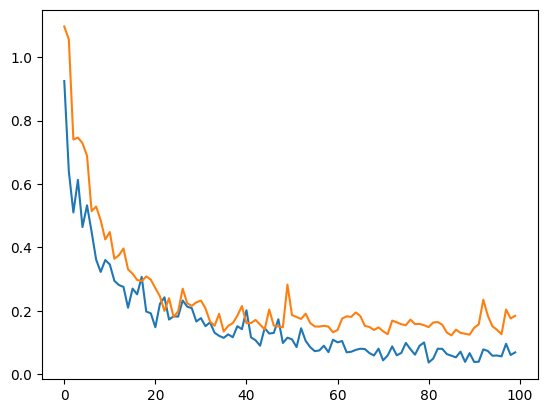

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Desempenho da rede
Após configurar e treinar a rede, realizaremos testes de desempenho para avaliar o funcionamento do modelo.

In [20]:
y_train_pred = model_cnn.predict(train_set_x_orig)
y_test_pred = model_cnn.predict(test_set_x_orig)

print('Acurácia sobre o arquivo de treino = {:.1f}%'.format(accuracy_score(train_set_y.argmax(axis=1), y_train_pred.argmax(axis=1)) * 100))
print('Acurácia sobre o arquivo de testes = {:.1f}%'.format(accuracy_score(test_set_y.argmax(axis=1), y_test_pred.argmax(axis=1)) * 100))

print('\nResultados esperados do arquivo de teste:', *test_set_y_orig)
print('Resultados obtidos do arquivo de teste:  ', *[y_test_pred[x].argmax() for x in range(len(y_test_pred))])

2/2 [==============================] - 0s 42ms/step
Acurácia sobre o arquivo de treino = 99.0%
Acurácia sobre o arquivo de testes = 82.0%

Resultados esperados do arquivo de teste: 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 0
Resultados obtidos do arquivo de teste:   1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0


Matriz de confusão
Com base nos resultados obtidos, construiremos uma matriz de confusão para analisar o desempenho do modelo em relação aos dados de teste.


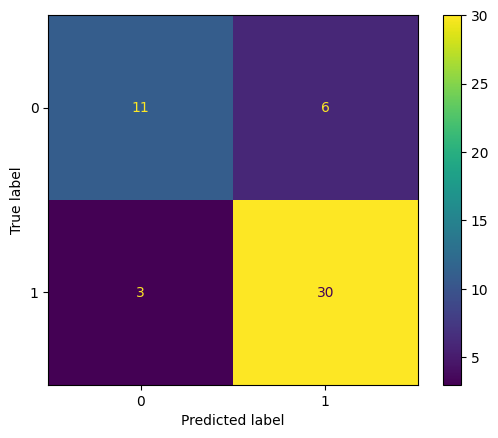

In [21]:
ConfusionMatrixDisplay.from_predictions(test_set_y.argmax(axis=1), y_test_pred.argmax(axis=1))